In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
pip install kagglehub torch torchvision timm matplotlib Pillow scikit-learn

  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
<ipython-input-1-6bf67b6bbea6>:88: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-1-6bf67b6bbea6>:98: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [1/10] | Loss: 0.1904 | Accuracy: 93.79%
Epoch [2/10] | Loss: 0.0526 | Accuracy: 98.41%
Epoch [3/10] | Loss: 0.0388 | Accuracy: 98.80%
Epoch [4/10] | Loss: 0.0370 | Accuracy: 98.93%
Epoch [5/10] | Loss: 0.0253 | Accuracy: 99.19%
Epoch [6/10] | Loss: 0.0302 | Accuracy: 99.15%
Epoch [7/10] | Loss: 0.0377 | Accuracy: 98.86%
Epoch [8/10] | Loss: 0.0222 | Accuracy: 99.41%
Epoch [9/10] | Loss: 0.0259 | Accuracy: 99.36%
Epoch [10/10] | Loss: 0.0294 | Accuracy: 99.19%
Test Accuracy: 98.21%
Precision: 0.9827
Sensitivity (Recall): 0.9821
F1 Score: 0.9814


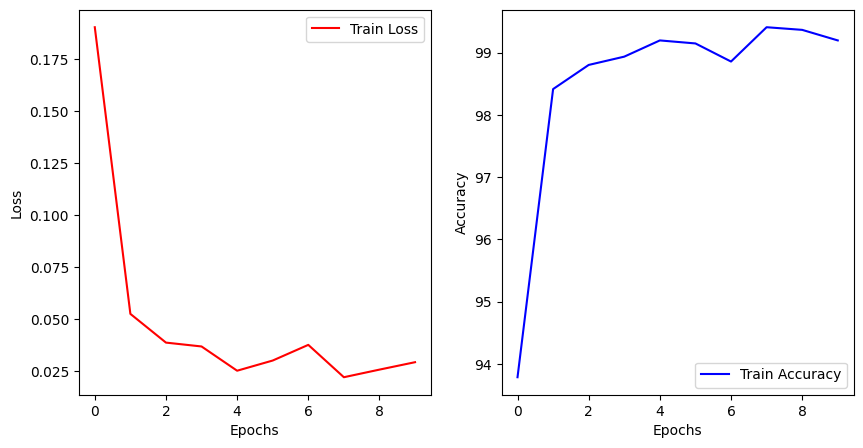

FileNotFoundError: [Errno 2] No such file or directory: '/content/potato.jpg'

In [ ]:
!pip install kagglehub timm scikit-learn

import kagglehub
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from PIL import Image
from torch.cuda.amp import autocast, GradScaler
import timm  # Import Swin Transformer from TIMM
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from collections import Counter

# ===========================
# DOWNLOAD DATASET
# ===========================
dataset_path = kagglehub.dataset_download("emmarex/plantdisease")
DATA_DIR = os.path.join(dataset_path, "PlantVillage")
if not os.path.exists(DATA_DIR):
    DATA_DIR = os.path.join(dataset_path, os.listdir(dataset_path)[0])

# ===========================
# CONFIGURATIONS
# ===========================
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===========================
# DATASET & TRANSFORMATIONS
# ===========================
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

full_dataset = datasets.ImageFolder(root=DATA_DIR, transform=train_transforms)
train_indices, test_indices = train_test_split(
    list(range(len(full_dataset))),
    test_size=0.2,
    stratify=full_dataset.targets,
    random_state=42
)
train_data = torch.utils.data.Subset(full_dataset, train_indices)
test_data = torch.utils.data.Subset(full_dataset, test_indices)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)
NUM_CLASSES = len(full_dataset.classes)

# ===========================
# DEFINE MODEL
# ===========================
class PlantDiseaseSwin(nn.Module):
    def __init__(self, num_classes):
        super(PlantDiseaseSwin, self).__init__()
        self.swin = timm.create_model("swin_base_patch4_window7_224", pretrained=True)
        self.swin.head = nn.Identity()
        dummy_input = torch.randn(1, 3, 224, 224)
        with torch.no_grad():
            dummy_output = self.swin(dummy_input)
        self.num_features = dummy_output.size(1)
        height, width = dummy_output.shape[2], dummy_output.shape[3]
        self.fc = nn.Linear(self.num_features * height * width, num_classes)

    def forward(self, x):
        x = self.swin(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = PlantDiseaseSwin(num_classes=NUM_CLASSES).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scaler = GradScaler()

def train(model, train_loader, criterion, optimizer, epochs):
    model.train()
    train_losses, train_accuracies = [], []
    for epoch in range(epochs):
        total_loss, correct, total = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            total_loss += loss.item()
        train_losses.append(total_loss / len(train_loader))
        train_accuracies.append(100 * correct / total)
        print(f"Epoch [{epoch+1}/{epochs}] | Loss: {train_losses[-1]:.4f} | Accuracy: {train_accuracies[-1]:.2f}%")
    return train_losses, train_accuracies

def evaluate(model, test_loader):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    test_accuracy = 100 * correct / total
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    print(f"Test Accuracy: {test_accuracy:.2f}%")
    print(f"Precision: {precision:.4f}")
    print(f"Sensitivity (Recall): {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

def plot_graphs(train_losses, train_accuracies):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def predict_image(image_path, model, class_names):
    model.eval()
    image = Image.open(image_path)
    image = test_transforms(image).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        output = model(image)
        predicted = torch.argmax(output, dim=1)
    predicted_class = class_names[predicted.item()]
    print(f"Predicted Class: {predicted_class}")
    plt.imshow(Image.open(image_path))
    plt.title(f"Predicted: {predicted_class}")
    plt.show()

train_losses, train_accuracies = train(model, train_loader, criterion, optimizer, EPOCHS)
evaluate(model, test_loader)
plot_graphs(train_losses, train_accuracies)
class_names = full_dataset.classes
fixed_image_path = "/content/potato img.jpeg"
predict_image(fixed_image_path, model, class_names)

Predicted Class: Potato___Early_blight


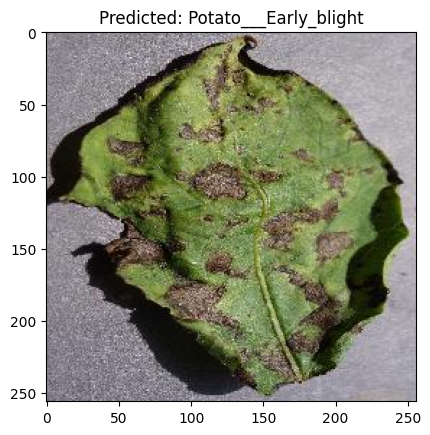

In [ ]:
class_names = full_dataset.classes
fixed_image_path = "/content/potato img.jpeg"
predict_image(fixed_image_path, model, class_names)